<a href="https://colab.research.google.com/github/Mugambi645/ml-and-dl-notebooks/blob/main/Classifying_newswires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Classifying newswires: A multiclass classification example</h2>
The task is single-label, multiclass classification: classify Reuters newswires into one of 46 topics. If data points could belong to multiple topics, it would be multilabel, multiclass.

The *Reuters dataset*.
We’ll work with the Reuters dataset, a set of short newswires and their topics, published by Reuters in 1986. It’s a simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

In [1]:
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000
)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


 We have 8,982 training examples and 2,246 test examples:

In [2]:
len(train_data)


8982

In [3]:
len(test_data)

2246

In [4]:
# Each example is a list of integers(word indices)
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [5]:
# decoding it into words
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join(
     # The indices are offset by 3 because 0, 1, and 2 are reserved
    # indices for "padding," "start of sequence," and "unknown."
     [reverse_word_index.get(i - 3, "?") for i in train_data[10]]
)

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


The label associated with an example is an integer between 0 and 45 — a topic index:

In [6]:
train_labels[10]

np.int64(3)

<h3>Preparing the data</h3>

In [10]:
import numpy as np

def multi_hot_encode(sequences, num_classes):
    results = np.zeros((len(sequences), num_classes))
    for i, seq in enumerate(sequences):
        results[i, seq] = 1.0
    return results



In [11]:
# Vectorized training data
x_train = multi_hot_encode(train_data, num_classes=10000)
# Vectorized test data
x_test = multi_hot_encode(test_data, num_classes=10000)

Labels can be left as integers or one-hot encoded, which represents each label as a vector of 0s with a 1 at the index corresponding to the class.

In [12]:
import numpy as np

def one_hot_encode(labels, num_classes=46):
  results = np.zeros((len(labels), num_classes))
  for i, label in enumerate(labels):
    results[i, labels] = 1.0
  return results
# Vectorized training labels
y_train = one_hot_encode(train_labels)
# Vectorized test labels
y_test = one_hot_encode(test_labels)

In [13]:
# using built in keras way
from keras.utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

<h3>Building Your Model</h3>
For topic classification, you now have 46 output classes instead of 2, which greatly increases the complexity of the task. In a stack of Dense layers, each layer can only use information passed from the one before it. If a layer is too small, it may lose important information that later layers cannot recover—this creates an information bottleneck.

In the earlier binary classification example, 16-unit hidden layers worked, but for 46 classes, that size is too small. To avoid bottlenecks and capture more features, you should use larger intermediate layers, such as 64 units, so the model has enough capacity to separate many classes.

In [14]:
import keras
from keras import layers
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(46, activation="softmax"),
    ]
)



The model ends with a **Dense(46)** layer using **softmax**, which outputs a probability distribution over 46 classes — each value represents the probability that the sample belongs to that class, and all probabilities sum to 1.

The best loss function is **categorical_crossentropy**, because it measures how close the predicted probability distribution is to the true one.

Accuracy alone can be misleading for this task, since predicting the correct class as the second-best choice still counts as incorrect. A better evaluation metric is **top-k accuracy** (e.g., top-3), which checks whether the correct class appears among the top k predicted probabilities.


In [15]:
top_3_accuracy = keras.metrics.TopKCategoricalAccuracy(
    k=3, name="top_3_accuracy"
)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", top_3_accuracy],
)

<h3>Validating our approach</h3>
Let’s set apart 1,000 samples in the training data to use as a validation set.

In [16]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [17]:
# train the model for 20 epochs
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val),

    )

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.2971 - loss: 3.5849 - top_3_accuracy: 0.4329 - val_accuracy: 0.5310 - val_loss: 2.5525 - val_top_3_accuracy: 0.6820
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5847 - loss: 2.1713 - top_3_accuracy: 0.7352 - val_accuracy: 0.6560 - val_loss: 1.5901 - val_top_3_accuracy: 0.7720
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7145 - loss: 1.3717 - top_3_accuracy: 0.8087 - val_accuracy: 0.7180 - val_loss: 1.2526 - val_top_3_accuracy: 0.8290
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7816 - loss: 1.0104 - top_3_accuracy: 0.8734 - val_accuracy: 0.7550 - val_loss: 1.1094 - val_top_3_accuracy: 0.8630
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8266 - loss: 0.8079 - top_3_accuracy: 0.9092 - val_accuracy: 0.7930 - val_loss: 1.0162 - val_top_3_accuracy: 0.8790
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8642 - loss: 0.6316 - top_3_a

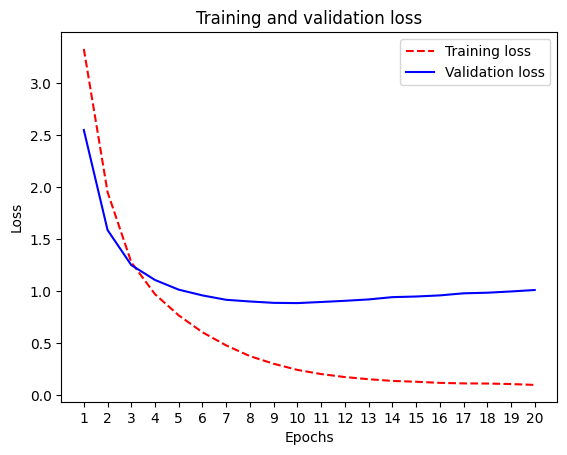

In [18]:
import matplotlib.pyplot as plt

# display loss and accuracy curves
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

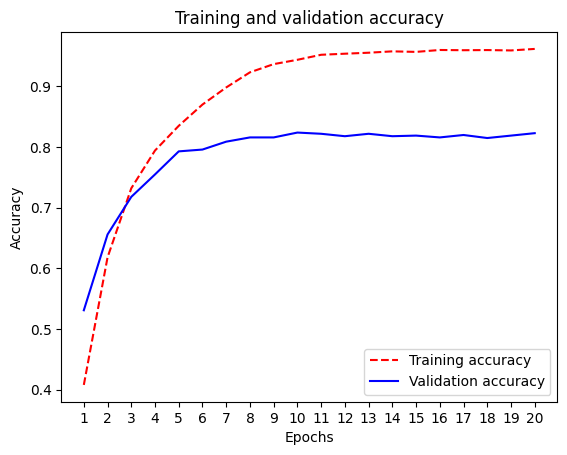

In [19]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "r--", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

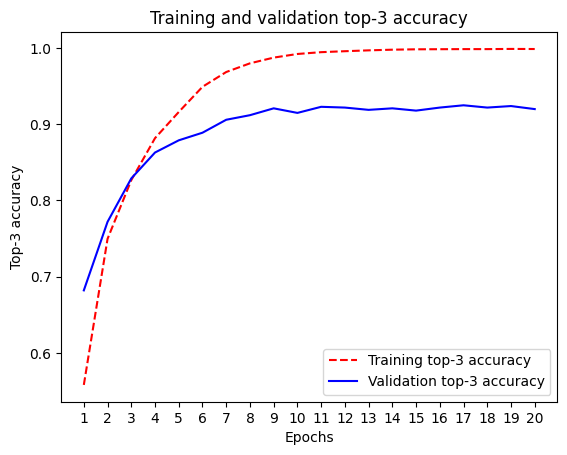

In [20]:
plt.clf()
acc = history.history["top_3_accuracy"]
val_acc = history.history["val_top_3_accuracy"]
plt.plot(epochs, acc, "r--", label="Training top-3 accuracy")
plt.plot(epochs, val_acc, "b", label="Validation top-3 accuracy")
plt.title("Training and validation top-3 accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Top-3 accuracy")
plt.legend()
plt.show()

The model begins to overfit after nine epochs. Let’s train a new model from scratch for nine epochs and then evaluate it on the test set.

In [21]:
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(46, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    x_train,
    y_train,
    epochs=9,
    batch_size=512,
)
results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.2724 - loss: 3.5742
Epoch 2/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6144 - loss: 2.0979
Epoch 3/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7395 - loss: 1.2792
Epoch 4/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7952 - loss: 0.9659
Epoch 5/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8396 - loss: 0.7515
Epoch 6/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8776 - loss: 0.5979
Epoch 7/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9029 - loss: 0.4567
Epoch 8/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9255 - loss: 0.3637
Epoch 9/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9363 - loss: 0.2915
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7996 - loss: 0.9189


In [22]:
results

[0.941407322883606, 0.7925200462341309]

This approach reaches an accuracy of approximately 80%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%. But in this case, we have 46 classes, and they may not be equally represented. What would be the accuracy of a random baseline? We could try quickly implementing one to check this empirically:

In [23]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels == test_labels_copy)
hits_array.mean()

np.float64(0.19456812110418523)

As you can see, a random classifier would score around 19% classification accuracy, so the results of our model seem pretty good in that light.

<h3>Generating predictions on new data</h3>
Calling the model’s predict method on new samples returns a class probability distribution over all 46 topics for each sample. Let’s generate topic predictions for all of the test data:

In [24]:
predictions = model.predict(x_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [26]:
 # Each entry in “predictions” is a vector of length 46:
predictions[0].shape

(46,)

In [27]:
# The coefficients in this vector sum to 1, as they form a probability distribution:
np.sum(predictions[0])

np.float32(1.0)

In [28]:
# highest probability
np.argmax(predictions[0])

np.int64(3)

In [29]:
predictions

array([[4.9016402e-05, 2.3280476e-04, 3.5066871e-05, ..., 1.4872566e-05,
        9.5961896e-06, 5.4871234e-06],
       [8.1595602e-03, 5.7385447e-03, 8.9327088e-03, ..., 1.8094127e-03,
        2.9322073e-05, 5.4380511e-05],
       [5.7461561e-04, 6.6051441e-01, 4.8765000e-03, ..., 3.3327655e-03,
        4.1177281e-04, 6.4316625e-04],
       ...,
       [1.7712013e-05, 2.9638445e-04, 1.5040058e-04, ..., 2.5344953e-05,
        3.4210381e-05, 3.2626940e-05],
       [1.3885464e-03, 1.5987188e-02, 2.6841054e-03, ..., 6.4321596e-04,
        4.3186793e-04, 3.1875315e-04],
       [7.6984536e-05, 3.9668894e-01, 3.1484552e-02, ..., 1.2289881e-03,
        1.5447980e-04, 7.0567745e-05]], dtype=float32)